# Índice

hacer indice

# 3. Entrenamiento de los modelos

## 3.1 Importación de las librerias

In [5]:
# General import and load data
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Splitting
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import sem

# Under - Over sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Optimization
from sklearn.model_selection import GridSearchCV

# Visualization
import matplotlib.pyplot as plt

print("Todas las librerias fueron correctamente importadas.")

Todas las librerias fueron correctamente importadas.


## 3.2 Funciones auxiliares y variables globales

Función utilizada para el calculo de la score media tras un cross validation

In [8]:
def mean_score(scores):
    return ("Score media: {0:.3f} (+/- {1:.3f})").format(np.mean(scores), sem(scores))

Función utilizado para evaluar los distintos umbrales en la curva de ROC.

In [10]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

Se fija un seed para todo el documento para fijar la aleatoriedad y así obtener resultados replicables.

In [12]:
seed = 42

## 3.3 Carga del dataframe

Se cargan los datos de la ruta *formated/train_exportado.csv*, los cuales son los datos ya procesados por uno de nuestros compañeros.

In [15]:
url = "formated/train_exportado.csv"
df = pd.read_csv(url)

print("\nDatos cargados correctamente")


Datos cargados correctamente


Se observan las dimensiones del dataframe.

In [17]:
print(f"Dimensiones del conjunto de datos: {df.shape[0]} filas y {df.shape[1]} columnas")

Dimensiones del conjunto de datos: 22575 filas y 32 columnas


## 3.4 Análisis y selección de las características

Se configura pandas para que muestre todas las columnas y después se realiza un head para ver el contenido de las mismas.

In [20]:
pd.set_option('display.max_columns', None)
df.head()

,ApprovalDate,ApprovalFY,NoEmp,CreateJob,RetainedJob,DisbursementDate,DisbursementGross,Accept,NewExist_Binary,Franchise_Binary,UrbanRural_Binary,RevLineCr_Binary,LowDoc_Binary,ApprovalDate_quarter,DisbursementDate_quarter,Bank_Categorized,Bank_Categorized_cod,BankState_Categorized_cod,ApprovalFY_Grouped,ApprovalFY_Grouped_cod,NoEmp_Grouped,NoEmp_Grouped_cod,CreateJob_Binary,RetainedJob_Binary,DisbursementGross_Grouped,DisbursementGross_Grouped_cod,BankState_DE,BankState_IL,BankState_OH,BankState_Otros,BankState_RI,BankState_Categorized
0,11,2006,2,0,2,12,8000,1,0,0,1,0,0,4,4,CITIZENS BANK NATL ASSOC,1,4,2005-2009,7,1-2,1,0,1,0-30k,0,0,0,0,0,1,RI
1,6,2005,2,1,2,7,166000,1,0,0,1,0,0,2,3,"FIRSTMERIT BANK, N.A.",4,2,2005-2009,7,1-2,1,1,1,150k-500k,3,0,0,1,0,0,OH
2,3,2003,2,4,2,3,25000,1,0,0,0,1,0,1,1,"PNC BANK, NATIONAL ASSOCIATION",9,2,2000-2004,6,1-2,1,1,1,0-30k,0,0,0,1,0,0,OH
3,6,1995,2,0,0,1,220100,1,0,0,1,0,0,2,1,THE HUNTINGTON NATIONAL BANK,10,2,1995-1999,5,1-2,1,0,0,150k-500k,3,0,0,1,0,0,OH
4,4,2009,0,0,0,5,25000,0,1,0,1,0,0,2,2,THE HUNTINGTON NATIONAL BANK,10,2,2005-2009,7,0,0,0,0,0-30k,0,0,0,1,0,0,OH


Se muestran todas las columnas para poder observarlas.

In [22]:
df.columns

Index(['ApprovalDate', 'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob',
       'DisbursementDate', 'DisbursementGross', 'Accept', 'NewExist_Binary',
       'Franchise_Binary', 'UrbanRural_Binary', 'RevLineCr_Binary',
       'LowDoc_Binary', 'ApprovalDate_quarter', 'DisbursementDate_quarter',
       'Bank_Categorized', 'Bank_Categorized_cod', 'BankState_Categorized_cod',
       'ApprovalFY_Grouped', 'ApprovalFY_Grouped_cod', 'NoEmp_Grouped',
       'NoEmp_Grouped_cod', 'CreateJob_Binary', 'RetainedJob_Binary',
       'DisbursementGross_Grouped', 'DisbursementGross_Grouped_cod',
       'BankState_DE', 'BankState_IL', 'BankState_OH', 'BankState_Otros',
       'BankState_RI', 'BankState_Categorized'],
      dtype='object')

Se muestran todas las columnas en formato código para que sea más sencillo su uso. Además se estructuran en diversas categorias.

In [24]:
all_features = [
    # Caracteristicas numericas
    'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross',

    # Caracteristicas categoricas binarias
    'NewExist_Binary', 'Franchise_Binary', 'UrbanRural_Binary',
    'RevLineCr_Binary', 'LowDoc_Binary', 'CreateJob_Binary',
    'RetainedJob_Binary',

    # Caracteristicas categoricas codificadas
    'ApprovalDate', 'DisbursementDate', 'Bank_Categorized_cod', 
    'BankState_Categorized_cod', 'ApprovalFY_Grouped_cod', 
    'NoEmp_Grouped_cod', 'DisbursementGross_Grouped_cod',

    # Características con relación temporal
    'ApprovalDate_quarter', 'DisbursementDate_quarter',

    # Caracteristicas categoricas sin codificadar
    'Bank_Categorized', 'ApprovalFY_Grouped',        
    'DisbursementGross_Grouped', 'BankState_Categorized',

    # Caracteristicas relacionadas con BankState_Categorized tras un One Hot Encoding
    'BankState_DE', 'BankState_IL', 'BankState_OH', 
    'BankState_Otros', 'BankState_RI'
]

Se seleccionan todas las características a excepción de las categoricas sin codificadar, al ya tener la misma információn codificada.

In [26]:
selected_features = [
    # Caracteristicas numericas
    'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross',

    # Caracteristicas categoricas binarias
    'NewExist_Binary', 'Franchise_Binary', 'UrbanRural_Binary',
    'RevLineCr_Binary', 'LowDoc_Binary', 'CreateJob_Binary',
    'RetainedJob_Binary',

    # Caracteristicas categoricas codificadas
    'Bank_Categorized_cod', 'BankState_Categorized_cod',
    'ApprovalFY_Grouped_cod', 'NoEmp_Grouped_cod', 
    'DisbursementGross_Grouped_cod',

     # Time-related features
    'ApprovalDate_quarter', 'DisbursementDate_quarter',

    # Caracteristicas relacionadas con BankState_Categorized tras un One Hot Encoding
    'BankState_DE', 'BankState_IL', 'BankState_OH', 
    'BankState_Otros', 'BankState_RI'
]

De las cuales son realmente numericas las siguientes:

In [28]:
numeric_vars = ['ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross']

Comprobamos que solo tenemos tipos númericos, más especificamente enteros.

In [30]:
df[selected_features].dtypes

ApprovalFY                       int64
NoEmp                            int64
CreateJob                        int64
RetainedJob                      int64
DisbursementGross                int64
NewExist_Binary                  int64
Franchise_Binary                 int64
UrbanRural_Binary                int64
RevLineCr_Binary                 int64
LowDoc_Binary                    int64
CreateJob_Binary                 int64
RetainedJob_Binary               int64
Bank_Categorized_cod             int64
BankState_Categorized_cod        int64
ApprovalFY_Grouped_cod           int64
NoEmp_Grouped_cod                int64
DisbursementGross_Grouped_cod    int64
ApprovalDate_quarter             int64
DisbursementDate_quarter         int64
BankState_DE                     int64
BankState_IL                     int64
BankState_OH                     int64
BankState_Otros                  int64
BankState_RI                     int64
dtype: object

## 3.5 Carga de los datos y división en entrenamiento y test

Cargamos las caracteristicas seleccionadas en la variable X y el objetivo *Accept* en la variable y.

In [33]:
X = df[selected_features] 
y = df['Accept'].values

Mostramos las dimensiones de ambas variables.

In [35]:
print(f"Dimensiones del conjunto de datos: {X.shape[0]} filas y {X.shape[1]} columnas")
print(f"Dimensiones del conjunto de datos: {y.shape[0]} filas y 1 columna")

Dimensiones del conjunto de datos: 22575 filas y 24 columnas
Dimensiones del conjunto de datos: 22575 filas y 1 columna


Obtenemos la distribución del objetivo *Accept*.

In [37]:
# Calcular los conteos de valores
counts = pd.Series(y).value_counts()

# Calcular los porcentajes
percentages = (counts / len(y)) * 100

# Mostrar los resultados
print(percentages)

1    83.184939
0    16.815061
Name: count, dtype: float64


En definitiva, observamos que esta desbalanceado

Se separa ya en entrenamiento y test para no falsear los datos del test al realizar el balanceo.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## 3.6 Preprocesado de los datos

### 3.6.1 Introducción

Si observamos el notebook en el que se escogen qué modelos son mejores veremos que se han estándarizado todas las características y se ha realizado un oversampling mediante *SMOTE* con los hiperparámetros por defecto (es decir que hará que la proporcion final sea un 50-50). Después de ello, también se hacía un *PCA* para reducir la dimensionalidad.

Al no estar seguros de si esa era la mejor opción, se han realizado cuatro casuísticas para analizar cual es el mejor orden. El caso 1 hace referencia a estandarizar todas las caracteristicas y realizar un *SMOTE* con los valores por defecto. El caso 2 hace referencia a estandarizar solo las caracteristicas númericas y realizar un *SMOTE* con los valores por defecto. El caso 3 hace referencia a estandarizar todas las caracteristicas y después realizar un undersampling mediante *RandomUnderSampler* y un *SMOTE* sin los valores por defecto. El caso 4 hace referencia a estandarizar solo las caracteristicas númericas y después realizar un *RandomUnderSampler* y un *SMOTE* sin los valores por defecto.

Para la evaluación se ha realizado un *K-fold* con Random Forest como modelo, al ser el modelo que mejor funcionaba en el notebook de la selección de modelos (tanto en F1-score como en ROC-AUC score).

En el siguiente subapartado se han identificado todas las variables con un sufijo para determinar al caso de preprocesado al que se refiere. Los sufijos en cuestion son los siguientes:
* *_A_O*&nbsp;:&nbsp;&nbsp;*_All_OverUnder*, es decir, se estandarizan todas las características y se realiza solamente oversampling.
* *_N_O*&nbsp;:&nbsp;&nbsp;*_Number_Over*, es decir, se estandarizan solo las características numericas y se realiza solamente oversampling.
* *_A_OU*&nbsp;:&nbsp;&nbsp;*_All_OverUnder*, es decir, se estandarizan todas las características y se realiza tanto oversampling como undersampling.
* *_N_OU*&nbsp;:&nbsp;&nbsp;*_Number_OverUnder*, es decir, se estandarizan solo las características numericas y se realiza tanto oversampling como undersampling.

### 3.6.2 Casos de preprocesado

#### - Caso 1: Estandarización de todas las features y oversampling

Primero escalamos *X* con el escalador estándar.

In [47]:
prep_A_O = StandardScaler().fit(X_train)
X_scaled_A_O = prep_A_O.transform(X_train)

Después realizamos un SMOTE para obtener una proporción 50-50.

In [49]:
ovsamp_A_O = SMOTE(random_state=seed)
X_resampled_A_O, y_resampled_A_O = ovsamp_A_O.fit_resample(X_scaled_A_O, y_train)

Comprobamos el balanceo de los datos.

In [51]:
# Calcular los conteos de valores
counts = pd.Series(y_resampled_A_O).value_counts()

# Calcular los porcentajes
percentages = (counts / len(y_resampled_A_O)) * 100

# Mostrar los resultados
print(percentages)

1    50.0
0    50.0
Name: count, dtype: float64


Se realiza la reducción de características mediante *PCA*.

In [53]:
pca_A_O = PCA()
X_pca_full_A_O = pca_A_O.fit_transform(X_resampled_A_O)

Como ocurría en el notebook de selección de características, buscamos quedarnos solamente con los componentes que nos permitan tener un 95% de ratio de varianza.

Para ello, primero vemos una representación visual.

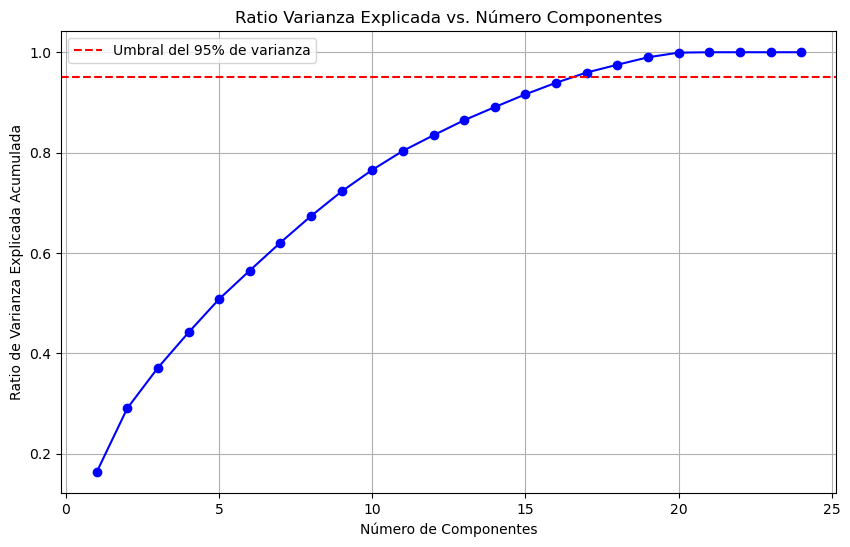

In [55]:
# Calculate cumulative explained variance ratio
cumulative_variance_ratio_A_O = np.cumsum(pca_A_O.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio_A_O) + 1), 
         cumulative_variance_ratio_A_O, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Ratio de Varianza Explicada Acumulada')
plt.title('Ratio Varianza Explicada vs. Número Componentes')
plt.grid(True)

# Add threshold line
plt.axhline(y=0.95, color='r', linestyle='--', 
            label='Umbral del 95% de varianza')
plt.legend()
plt.show()

Y ahora, seleccionamos el número de componentes, así como el desglose que aporta cada uno de ellos al ratio de varianza explicada.

In [57]:
n_comp_A_O = np.argmax(cumulative_variance_ratio_A_O >= 0.95) + 1
print(f"Número de componentes seleccionados: {n_comp_A_O}")
print(f"Varianza explicada con {n_comp_A_O} componentes: "
      f"{cumulative_variance_ratio_A_O[n_comp_A_O-1]:.4f}")

# Display variance explained by each component
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(pca_A_O.explained_variance_ratio_[:n_comp_A_O]):
    print(f"Componente {i+1}: {var:.4f} ({var*100:.2f}%)")

Número de componentes seleccionados: 17
Varianza explicada con 17 componentes: 0.9596

Varianza explicada por cada componente:
Componente 1: 0.1635 (16.35%)
Componente 2: 0.1273 (12.73%)
Componente 3: 0.0807 (8.07%)
Componente 4: 0.0704 (7.04%)
Componente 5: 0.0666 (6.66%)
Componente 6: 0.0568 (5.68%)
Componente 7: 0.0557 (5.57%)
Componente 8: 0.0529 (5.29%)
Componente 9: 0.0490 (4.90%)
Componente 10: 0.0430 (4.30%)
Componente 11: 0.0378 (3.78%)
Componente 12: 0.0312 (3.12%)
Componente 13: 0.0300 (3.00%)
Componente 14: 0.0261 (2.61%)
Componente 15: 0.0254 (2.54%)
Componente 16: 0.0230 (2.30%)
Componente 17: 0.0204 (2.04%)


Finalmente, nos quedamos con el conjunto de componentes deseado.

In [59]:
X_pca_A_O = X_pca_full_A_O[:, :n_comp_A_O]

#### - Caso 2: Estandarización de las features numericas y oversampling

Ahora solamente seleccionamos las variables numericas.

In [62]:
prep_N_O = ColumnTransformer([
    ('numericas', StandardScaler(), numeric_vars)
], remainder='passthrough').fit(X_train) 

X_scaled_N_O = prep_N_O.transform(X_train) 

Volvemos a realizar un oversampling con *SMOTE* por defecto.

In [64]:
ovsamp_N_O = SMOTE(random_state=seed)
X_resampled_N_O, y_resampled_N_O = ovsamp_N_O.fit_resample(X_scaled_N_O, y_train)

Realizamos el *PCA*.

In [66]:
pca_N_O = PCA()
X_pca_full_N_O = pca_N_O.fit_transform(X_resampled_N_O)

Y obtenemos sus componentes principales.

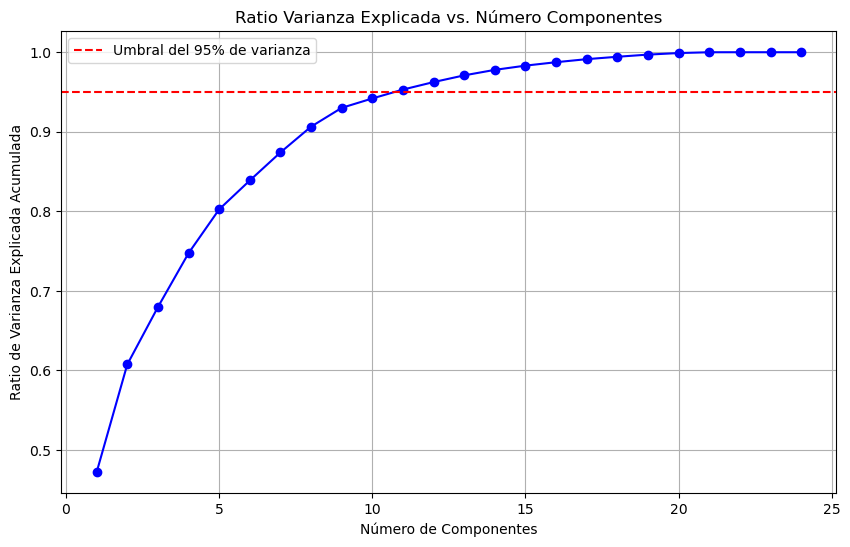

In [68]:
# Calculate cumulative explained variance ratio
cumulative_variance_ratio_N_O = np.cumsum(pca_N_O.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio_N_O) + 1), 
         cumulative_variance_ratio_N_O, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Ratio de Varianza Explicada Acumulada')
plt.title('Ratio Varianza Explicada vs. Número Componentes')
plt.grid(True)

# Add threshold line
plt.axhline(y=0.95, color='r', linestyle='--', 
            label='Umbral del 95% de varianza')
plt.legend()
plt.show()

In [69]:
n_comp_N_O = np.argmax(cumulative_variance_ratio_N_O >= 0.95) + 1
print(f"Número de componentes seleccionados: {n_comp_N_O}")
print(f"Varianza explicada con {n_comp_N_O} componentes: "
      f"{cumulative_variance_ratio_N_O[n_comp_N_O-1]:.4f}")

# Display variance explained by each component
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(pca_N_O.explained_variance_ratio_[:n_comp_N_O]):
    print(f"Componente {i+1}: {var:.4f} ({var*100:.2f}%)")

Número de componentes seleccionados: 11
Varianza explicada con 11 componentes: 0.9531

Varianza explicada por cada componente:
Componente 1: 0.4722 (47.22%)
Componente 2: 0.1354 (13.54%)
Componente 3: 0.0721 (7.21%)
Componente 4: 0.0677 (6.77%)
Componente 5: 0.0551 (5.51%)
Componente 6: 0.0363 (3.63%)
Componente 7: 0.0353 (3.53%)
Componente 8: 0.0324 (3.24%)
Componente 9: 0.0236 (2.36%)
Componente 10: 0.0118 (1.18%)
Componente 11: 0.0112 (1.12%)


Finalmente los seleccionamos.

In [71]:
X_pca_N_O = X_pca_full_N_O[:, :n_comp_N_O]

#### - Caso 3: Estandarización de todas las features y under- y oversampling

Estandarizamos para todas las características.

In [74]:
prep_A_OU = StandardScaler().fit(X_train)
X_scaled_A_OU = prep_A_OU.transform(X_train)

Esta vez, hacemos previamente un undersampling de los datos, buscando no ser tan agresivos al balancear el conjunto.

In [76]:
unsamp_A_OU = RandomUnderSampler(sampling_strategy=0.25, random_state=seed)
X_undersampled_A_OU, y_undersampled_A_OU = unsamp_A_OU.fit_resample(X_scaled_A_OU, y_train)

In [77]:
# Calcular los conteos de valores
counts = pd.Series(y_undersampled_A_OU).value_counts()

# Calcular los porcentajes
percentages = (counts / len(y_undersampled_A_OU)) * 100

# Mostrar los resultados
print(percentages)

1    80.0
0    20.0
Name: count, dtype: float64


Después realizamos un SMOTE para obtener una proporción 65-35 (aproximadamente).

In [79]:
ovsamp_A_OU = SMOTE(sampling_strategy=0.5, random_state=seed)
X_resampled_A_OU, y_resampled_A_OU = ovsamp_A_OU.fit_resample(X_undersampled_A_OU, y_undersampled_A_OU)

In [80]:
# Calcular los conteos de valores
counts = pd.Series(y_resampled_A_OU).value_counts()

# Calcular los porcentajes
percentages = (counts / len(y_resampled_A_OU)) * 100

# Mostrar los resultados
print(percentages)

1    66.666667
0    33.333333
Name: count, dtype: float64


Se realiza la reducción de características mediante *PCA*.

In [82]:
pca_A_OU= PCA()
X_pca_full_A_OU = pca_A_OU.fit_transform(X_resampled_A_OU)

Obtenemos sus componentes principales.

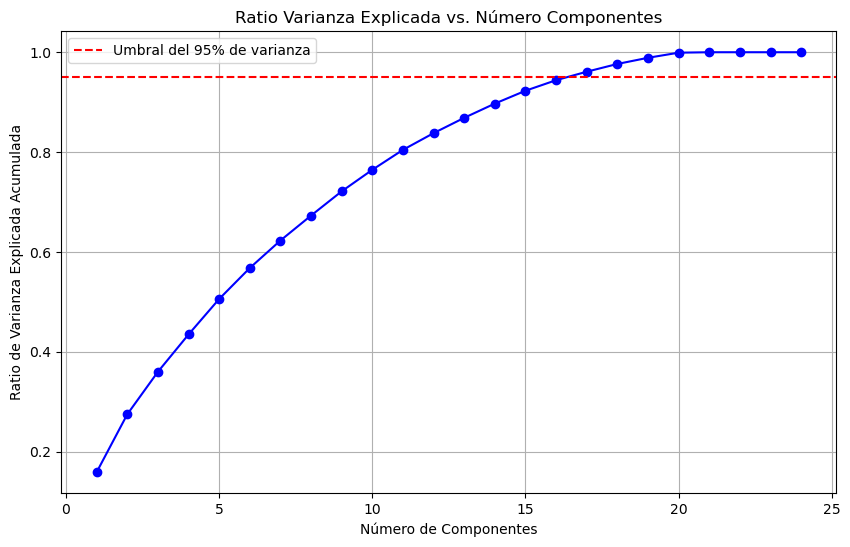

In [84]:
# Calculate cumulative explained variance ratio
cumulative_variance_ratio_A_OU = np.cumsum(pca_A_OU.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio_A_OU) + 1), 
         cumulative_variance_ratio_A_OU, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Ratio de Varianza Explicada Acumulada')
plt.title('Ratio Varianza Explicada vs. Número Componentes')
plt.grid(True)

# Add threshold line
plt.axhline(y=0.95, color='r', linestyle='--', 
            label='Umbral del 95% de varianza')
plt.legend()
plt.show()

In [85]:
n_comp_A_OU = np.argmax(cumulative_variance_ratio_A_OU >= 0.95) + 1
print(f"Número de componentes seleccionados: {n_comp_A_OU}")
print(f"Varianza explicada con {n_comp_A_OU} componentes: "
      f"{cumulative_variance_ratio_A_OU[n_comp_A_OU-1]:.4f}")

# Display variance explained by each component
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(pca_A_OU.explained_variance_ratio_[:n_comp_A_OU]):
    print(f"Componente {i+1}: {var:.4f} ({var*100:.2f}%)")

Número de componentes seleccionados: 17
Varianza explicada con 17 componentes: 0.9610

Varianza explicada por cada componente:
Componente 1: 0.1590 (15.90%)
Componente 2: 0.1159 (11.59%)
Componente 3: 0.0852 (8.52%)
Componente 4: 0.0747 (7.47%)
Componente 5: 0.0711 (7.11%)
Componente 6: 0.0620 (6.20%)
Componente 7: 0.0550 (5.50%)
Componente 8: 0.0500 (5.00%)
Componente 9: 0.0486 (4.86%)
Componente 10: 0.0431 (4.31%)
Componente 11: 0.0399 (3.99%)
Componente 12: 0.0335 (3.35%)
Componente 13: 0.0307 (3.07%)
Componente 14: 0.0285 (2.85%)
Componente 15: 0.0257 (2.57%)
Componente 16: 0.0211 (2.11%)
Componente 17: 0.0170 (1.70%)


Finalmente los seleccionamos

In [87]:
X_pca_A_OU = X_pca_full_A_OU[:, :n_comp_A_OU]

#### - Caso 4: Estandarización de las features numericas y under- y oversampling

Estandarizamos para todas las características.

In [90]:
prep_N_OU = ColumnTransformer([
    ('numericas', StandardScaler(), numeric_vars)
], remainder='passthrough').fit(X_train) 

X_scaled_N_OU = prep_N_OU.transform(X_train) 

Se vuelve a realizar el balanceo en dos pasos.

In [92]:
unsamp_N_OU = RandomUnderSampler(sampling_strategy=0.25, random_state=seed)
X_undersampled_N_OU, y_undersampled_N_OU = unsamp_N_OU.fit_resample(X_scaled_N_OU, y_train)

ovsamp_N_OU = SMOTE(sampling_strategy=0.5, random_state=seed)
X_resampled_N_OU, y_resampled_N_OU = ovsamp_N_OU.fit_resample(X_undersampled_N_OU, y_undersampled_N_OU)

Se realiza la reducción de características mediante *PCA*.

In [94]:
pca_N_OU= PCA()
X_pca_full_N_OU = pca_N_OU.fit_transform(X_resampled_N_OU)

Obtenemos sus componentes principales.

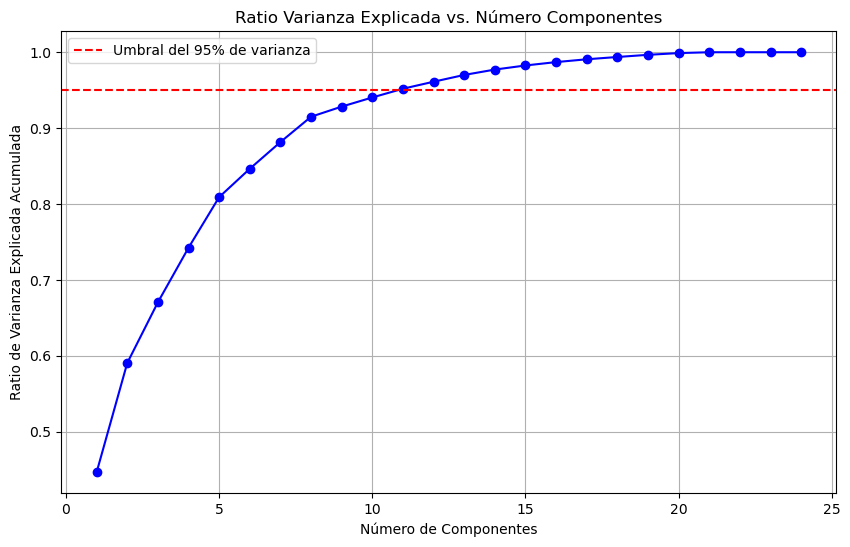

In [96]:
# Calculate cumulative explained variance ratio
cumulative_variance_ratio_N_OU = np.cumsum(pca_N_OU.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio_N_OU) + 1), 
         cumulative_variance_ratio_N_OU, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Ratio de Varianza Explicada Acumulada')
plt.title('Ratio Varianza Explicada vs. Número Componentes')
plt.grid(True)

# Add threshold line
plt.axhline(y=0.95, color='r', linestyle='--', 
            label='Umbral del 95% de varianza')
plt.legend()
plt.show()

In [97]:
n_comp_N_OU = np.argmax(cumulative_variance_ratio_N_OU >= 0.95) + 1
print(f"Número de componentes seleccionados: {n_comp_N_OU}")
print(f"Varianza explicada con {n_comp_N_OU} componentes: "
      f"{cumulative_variance_ratio_N_OU[n_comp_N_OU-1]:.4f}")

# Display variance explained by each component
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(pca_N_OU.explained_variance_ratio_[:n_comp_N_OU]):
    print(f"Componente {i+1}: {var:.4f} ({var*100:.2f}%)")

Número de componentes seleccionados: 11
Varianza explicada con 11 componentes: 0.9519

Varianza explicada por cada componente:
Componente 1: 0.4467 (44.67%)
Componente 2: 0.1439 (14.39%)
Componente 3: 0.0800 (8.00%)
Componente 4: 0.0719 (7.19%)
Componente 5: 0.0667 (6.67%)
Componente 6: 0.0373 (3.73%)
Componente 7: 0.0352 (3.52%)
Componente 8: 0.0334 (3.34%)
Componente 9: 0.0134 (1.34%)
Componente 10: 0.0121 (1.21%)
Componente 11: 0.0115 (1.15%)


Finalmente los seleccionamos

In [99]:
X_pca_N_OU = X_pca_full_N_OU[:, :n_comp_N_OU]

#### - Evaluación y conclusiones

Como se ha mencionado en la introducción de este apartado, se ha escogido Random Forest para esta evaluación al tratarse del mejor modelo del notebook anterior, tanto por F1-score como por ROC-AUX score.

In [102]:
model_sel = RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=seed)

Se ha evaluado la score media mediante un cross validation 5-fold.

In [104]:
# Caso 1: Estandarización a todas y solo Oversampling
#cv_A_O = KFold(5, shuffle=True, random_state=seed)
#scores_A_O = cross_val_score(model_sel, X_pca_A_O, y_resampled_A_O, cv=cv_A_O)
#print("Caso 1:",mean_score(scores_A_O))

# Caso 2: Estandarización a las numericas y solo Oversampling
#cv_N_O = KFold(5, shuffle=True, random_state=seed)
#scores_N_O = cross_val_score(model_sel, X_pca_N_O, y_resampled_N_O, cv=cv_N_O)
#print("Caso 2:",mean_score(scores_N_O))

# Caso 3: Estandarización a todas y tanto under como oversampling
#cv_A_OU = KFold(5, shuffle=True, random_state=seed)
#scores_A_OU = cross_val_score(model_sel, X_pca_A_OU, y_resampled_A_OU, cv=cv_A_OU)
#print("Caso 3:",mean_score(scores_A_OU))

# Caso 4: Estandarización a las numericas y tanto under como oversampling
#cv_N_OU = KFold(5, shuffle=True, random_state=seed)
#scores_N_OU = cross_val_score(model_sel, X_pca_N_OU, y_resampled_N_OU, cv=cv_N_OU)
#print("Caso 4:",mean_score(scores_N_OU))

Se ha decidido seguir con todos los casos en siguientes apartados, el motivo principal es que tras ejecutar pruebas con los modelos en el siguiente apartado nos dimos cuenta de que las score obtenidas estaban falseadas, ya que lo que peor hace el modelo es predecir los 0s. Como en este apartado se ha realizado un *SMOTE* para balancear el conjunto de datos, todos los valores sinteticos de 0s serán muy similares y los predice mejor de lo que realmente lo hace en el siguiente apartado. Además, como ya sabiamos, el score no es la mejor forma de evaluar el modelo al estar desbalanceado, es más importante la matriz de confusión para observar el F1-score obtenidos en los 0s.

### 3.6.3 Optimización del preprocesado

Debido a que no se ha escogido entre ninguno de los cuatro casos, se ha utilizado este apartado para comprender el funcionamiento de los diferentes preprocesados utilizados para posteriormente intentar optimizar sus hiperparámetros para el modelo final. Por ello, en este apartado se uso como base el caso 3, ya que realiza los cuatro preprocesados utilizados (estandarización, undersampling, oversampling y *PCA*). En cuanto a la estandarización no se observó ningún hiperparámetro interesante para su optimización.

Respecto al undersampling, el único hiperparametro interesante de optimizar el la estrategia de muestreo. Esta se representa mediante un *float*, la cual hace referencia a la proporción deseada entre la clase minoritaria respecto a la mayoritaria. Los valores obtenidos fueron:
* sampling_strategy = 0.25 -> score = 0.810
* sampling_strategy = 0.35 -> score = 0.770
* sampling_strategy = 0.45 -> score = 0.735

No se podían probar más valores ya que un número menor de *sampling_strategy* daba error al implicar que debería reducir también muestras de la clase minoritaria y también un número mayor implicaria reducir muestras pero en el oversampling posterior (al estar fijado el *SMOTE* a 0.5). Aun así se puede determinar que a menor *sampling_strategy* mayor es el score. Cabe recalcar que este resultado es engañoso, ya que realmente lo que ocurre es que al aumentarlo se reduce el número de 1s, es decir, se entrena el modelo con menos datos (más especificamente de 1s). Esto hace que la predicción general baje pero puede estar detectando mejor los 0s al ser una proporción más balanceada.

Respecto al oversampling, los hiperparametros ha optimizar fueon tanto el *sampling_strategy* como el *k_neighbors*. Al pertenecer a la misma librería, el significado de *sampling_strategy* es el mismo que para undersampling. Con el hiperparámetro *k_neighbors* lo que significa es que internamente *SMOTE* utiliza un modelo KNN para realizar el sintetizado de los datos, es decir, que variar su valor significará variar el número de vecinos con el que balancea los datos. Los valores obtenidos para *sampling_strategy* fueron:
* sampling_strategy = 0.5 -> score = 0.810
* sampling_strategy = 0.7 -> score = 0.829
* sampling_strategy = 0.9 -> score = 0.846

Como suponiamos a mayor *sampling_strategy* mayor score, pero esto se debe a estar evaluandose con un k-fold y por lo tanto provocar que sea más fácil identificar los 0s falsamente. Este valor será interesante ver que provocá en la matriz de confusión y como afecta a la excactitud en el siguiente apartado donde el test no se ha preproceado con el *SMOTE*.

Los valores obtenidos con *k_neighbors* fueron:
* k_neighbors = 2 -> score = 0.821
* k_neighbors = 5 -> score = 0.810
* k_neighbors = 0.9 -> score = 0.797

Por lo tanto a menor número de vecinos, mayor es la score. Aun así esto vuelve a ser engañoso porque al evaluarlo con un k-fold es normal que esto ocurrá, porque hace que los datos con *Accept* igual a 0 sean más similares y con ello más facil de predecir entre sí. Por consiguiente, este hiperparámetro será interesante evaluarlo también en el siguiente apartado, para ver como afecta a la matriz de confusión y a la exactitud, ya que puede ser interesante inntroducir más ruido para ver si predice mejor los 0s no conocidos.

Respecto a la *PCA*, se probó a modificar el umbral del ratio de varianza explicada acumulada. Como es lógico a menor umbral, menor será la información para el entrenamiento (menos componentes de la *PCA*, menor reducción de dimensionalidad) y por lo tanto menor será el score obtenido. Se obtuvo:
* threshold = 85% -> score = 0.804.
* threshold = 90% -> score = 0.810.
* threshold = 95% -> score = 0.810.
* threshold = 99% -> score = 0.813.

Se observa que, a mayor umbral, mayor es el score (ya que utiliza más componentes y por lo tanto más información). Aun así dicho aumento no es significativo. En contra parte, la perdida de score entre el 85% y el 95% tampoco es significativa, a sabiendas de que si estamos generalizando más el modelo (al reducir más la dimensionalidad) y por lo tanto reduciendo su complejidad.

## 3.7 Modelos seleccionados

### 3.7.1 Introducción

En el anterior notebook se evaluaron 10 modelos tanto por F1 score como por ROC-AUC score. Los resultados de mayor a menor de los modelos respecto a la F1-Score fueron los siguientes:
* Random Forest: 0.867449
* MLP: 0.811513
* DecisionTree: 0.790538
* KNN: 0.767966
* LinearSVC: 0.664541
* LogReg: 0.663316
* SVC_sigmoid: 0.617281
* GaussianNB: 0.568654
* SVC_poly: 0.526099
* SVC_rbf: 0.411304

En cambio, los resultados de mayor a menor de los modelos respecto a la ROC-AUC Score fueron los siguientes:
* Random Forest: 0.934825
* MLP: 0.884770
* KNN: 0.874725
* DecisionTree: 0.795805
* LinearSVC: 0.715244
* LogReg: 0.715162
* GaussianNB: 0.705878
* SVC_rbf: 0.692410
* SVC_poly: 0.658396
* SVC_sigmoid: 0.556961

Se decidió entrenar y optimizar los hiperparámetros de cuatro modelos. Los modelos escogidos fueron Random Forest, MLP, KNN y LinearSVC, es decir, los cuatro primeros tanto por F1-score como por ROC-AUC score (se ha excluido Decision Tree por ya estar probando un clasificador basado en árbol de decisión, y en un principio mejor).

### 3.7.2 Selección del conjunto de entrenamiento preprocesado

Seleccionamos uno de los conjuntos preproceados del anterior apartado, para ello se han colocado en un array todos los preprocesados para solo tener que modificar la variable *case*, la cual hace referencia a cada uno de los casos.

En la siguiente celda se crea tanto la variable case, como los distintos arrays de preprocesado.

In [115]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4
case   = 4

# X_prep = X_`preprocess - todos los conjuntos X preprocesados
X_prep = [X_pca_A_O, X_pca_N_O, X_pca_A_OU, X_pca_N_OU]

# y_prep = y_`preprocess - todos los conjuntos y preprocesados
y_prep = [y_resampled_A_O, y_resampled_N_O, y_resampled_A_OU, y_resampled_N_OU]

# prep = preprocess - todos los preprocesadores (StandardScaler a todo o focalizado mediante ColumnTransformer
prep   = [prep_A_O, prep_N_O, prep_A_OU, prep_N_OU]

# pca - todos los posibles pca
pca    = [pca_A_O, pca_N_O, pca_A_OU, pca_N_OU]

# n_comp = number_components - todos los posibles numeros de componentes de PCA
n_comp = [n_comp_A_O, n_comp_N_O, n_comp_A_OU, n_comp_N_OU]

Se selecciona el conjunto de X e y para el entrenamiento a partir de la variable case y de los arrray de preprocesado.

In [117]:
X_sel = X_prep[case-1]
y_sel = y_prep[case-1]

Al igual que se realizaron procesos de preprocesado al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes. No es necesario realizar el undersampling ni el oversampling ya que eso eran tecnicás para balancear el entrenamiento. Solamente serán necesario realizar la misma estandarización de las características y aplicar la misma reducción de dimensionalidad.

In [119]:
X_test_scaled = prep[case-1].transform(X_test)
X_test_pca_full = pca[case-1].transform(X_test_scaled)
X_test_pca = X_test_pca_full[:, :n_comp[case-1]]

### 3.7.3 Clasificador Random Forest

#### - Definición

Definimos el modelo son el *random_state* fijado y el *class_weigth* balanceado. También se escoje *n_jobs* con valor -1 para utilizar todos los procesadores.

In [123]:
model_Forest = RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=seed)

#### - Entrenamiento y evaluación

Entrenamos el modelo y comprobamos su exactitud.

In [126]:
model_Forest.fit(X_sel, y_sel)

predicted_Forest = model_Forest.predict(X_test_pca)
expected_Forest = y_test

In [127]:
metrics.accuracy_score(expected_Forest, predicted_Forest)

0.8090808416389812

#### - Null accuracy

Ahora se va a evaluar si  el modelo siempre predice la clase más frecuente.

In [130]:
s_y_test = pd.Series(y_test)
s_y_test.value_counts()

1    3765
0     750
Name: count, dtype: int64

In [131]:
y_test.mean()

0.8338870431893688

In [132]:
1 - y_test.mean() 

0.1661129568106312

In [133]:
max(y_test.mean(), 1 - y_test.mean())

0.8338870431893688

In [134]:
s_y_test.value_counts().head(1) / len(y_test)

1    0.833887
Name: count, dtype: float64

Nuestra exactitud es de 0.809, la cual es peor que la *null accuracy*, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

#### - Matriz de confusión y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [139]:
print(metrics.confusion_matrix(expected_Forest, predicted_Forest))

[[ 252  498]
 [ 364 3401]]


In [141]:
print(classification_report(expected_Forest, predicted_Forest))

              precision    recall  f1-score   support

           0       0.41      0.34      0.37       750
           1       0.87      0.90      0.89      3765

    accuracy                           0.81      4515
   macro avg       0.64      0.62      0.63      4515
weighted avg       0.80      0.81      0.80      4515



Se observa lo que hemos estado comentando durante todo el documento, tenemos un f1-score del 0.89 para los 1s mientras que estamos obteniendo un 0.37 para los 0s

#### - ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

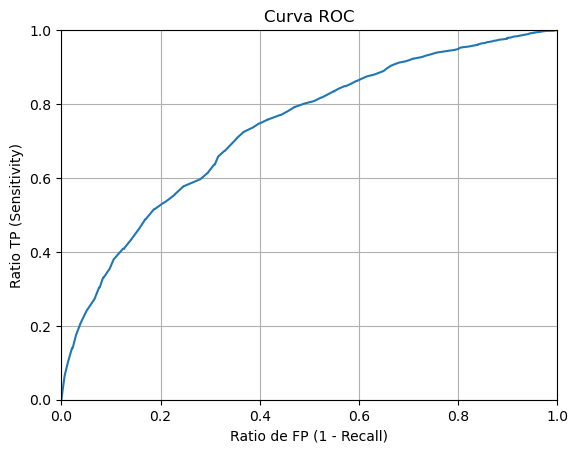

In [168]:
y_pred_prob_Forest = model_Forest.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [171]:
thresholds

array([       inf, 1.        , 0.99      , 0.986     , 0.98      ,
       0.97      , 0.962     , 0.96      , 0.95714286, 0.95      ,
       0.94424531, 0.94      , 0.9325    , 0.93      , 0.92      ,
       0.91555556, 0.91142857, 0.91      , 0.90833333, 0.90333333,
       0.902     , 0.9       , 0.89      , 0.88166667, 0.88      ,
       0.87714286, 0.875     , 0.872     , 0.87007659, 0.87      ,
       0.86      , 0.857     , 0.85      , 0.84714286, 0.842     ,
       0.84      , 0.83428571, 0.83088273, 0.83      , 0.82714286,
       0.82142857, 0.82      , 0.81090909, 0.81      , 0.80333333,
       0.8       , 0.792     , 0.79      , 0.78333333, 0.78      ,
       0.77416667, 0.77      , 0.76253968, 0.76      , 0.75961905,
       0.75810295, 0.75333333, 0.74      , 0.73555556, 0.73      ,
       0.725     , 0.72      , 0.71966311, 0.71333333, 0.71      ,
       0.704     , 0.70333333, 0.7       , 0.69666667, 0.695     ,
       0.69      , 0.68709524, 0.6825    , 0.68      , 0.67   

Sorprendentemente, el modelo muestra un mejor rendimiento del esperado, aunque se aboserva la situación con los 0s al aumentar más rápido el eje *x* respecto al eje *y*.

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

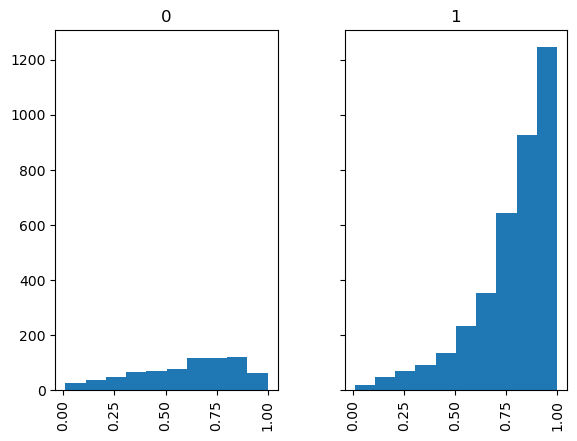

In [175]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra que los mejores resultados para ambas clases se obtiene con el *threshold* igual a 0.75.

In [178]:
evaluate_threshold(0.75)

Sensitivity: 0.6730411686586986
Recall: 0.6706666666666667


Finalmente se calcula el valor de AUC.

In [185]:
print(roc_auc_score(expected_Forest, predicted_Forest))

0.619660026560425


Se ha obtenido un valor entre 0.6 y 0.7, es decir, el modelo se considerá como pobre o *D*.

#### - Optimización

In [ ]:
model.get_params()

In [ ]:
gammas = np.logspace(-6, -1, 10)
gs = GridSearchCV(model, param_grid=dict(gamma=gammas))
gs.fit(X_train, y_train)

In [ ]:
print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

In [ ]:
arboles_decision = model_Forest.estimators_

profundidades = [arbol.tree_.max_depth for arbol in arboles_decision]
profundidad_media = np.mean(profundidades)

print(f"Profundidad media de los árboles: {profundidad_media}")

#### - Entramiento y evaluación con hiperparámetros optimizados

In [ ]:
model_opt = SVC(kernel=kernel, probability=True, gamma=gamma)

In [ ]:
model_opt.fit(X_train, y_train)

predicted = model_opt.predict(X_test)
expected = y_test

In [ ]:
metrics.accuracy_score(expected, predicted)

Hablar de la comparacion con el null accuracy

In [ ]:
print(metrics.confusion_matrix(expected, predicted))

In [ ]:
print(classification_report(expected, predicted))

In [ ]:
y_pred_prob = model_opt.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic')
plt.xlabel('False Positive Rate (1 - Recall)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

In [ ]:
thresholds

In [ ]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [ ]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

In [ ]:
evaluate_threshold(0.74)

In [ ]:
print(roc_auc_score(expected, predicted))

### 3.3.2 Clasificador Y